In [7]:
import numpy as np
from scipy import stats
#import cupy as cp
import matplotlib.pyplot as plt
import cv2

from lib_MHDPIC1D.pic1d import *
from lib_MHDPIC1D.mhd1d import *
from lib_MHDPIC1D.interface import *

Alfven波の伝搬 MHDのみ

In [8]:
c = 1.0
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 25
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 20 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.1*c)**2
Ti_pic = Te_pic / t_r
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
VA_pic = B0_pic / np.sqrt(ni0_pic * m_ion + ni0_pic * m_electron)
gamma_pic = 5.0 / 3.0
rho_pic = ni0_pic * m_ion + ne0_pic * m_electron
p_pic = ni0_pic * Ti_pic + ne0_pic * Te_pic
CS_pic = np.sqrt(gamma_pic * p_pic / rho_pic)
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)
ion_inertial_length = c / omega_pi

dx_pic = debye_length
nx_pic = 300
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 0.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[2, :] = B0_pic
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
for i in range(nx_pic):
    x_pic_ion[0, i * ni0_pic : (i+1) * ni0_pic] = (rs_ion.rand(ni0_pic) + i) * dx_pic
    x_pic_electron[0, i * ne0_pic : (i+1) * ne0_pic] = (rs_electron.rand(ne0_pic) + i) * dx_pic

v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion, random_state=30))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion, random_state=40))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion, random_state=50))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron, random_state=60))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron, random_state=70))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron, random_state=80))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")
print(f"ion inertial length is {ion_inertial_length:.1f}")

total number of particles is 12000.
Box size is 300
ion inertial length is 70.7


MHD初期化 \
U1は上半分、U2は下半分のつもり

In [9]:
gamma_mhd = 5.0 / 3.0
B0_mhd = B0_pic
rho0_mhd = ne0_pic * m_electron + ni0_pic * m_ion
p0_mhd = ne0_pic * Te_pic + ni0_pic * Ti_pic
VA_mhd = B0_mhd / np.sqrt(rho0_mhd)
CS_mhd = np.sqrt(gamma_mhd * p0_mhd / rho0_mhd)
Cf_mhd = np.sqrt(VA_mhd**2 + CS_mhd**2)
dx_mhd = dx_pic

nx_mhd = 350
x_min_mhd = 1e-10
x_max_mhd = nx_mhd * dx_mhd - 1e-10
dt_mhd = 0.0
CFL = 0.7
x_coordinate_mhd = np.arange(x_min_mhd, x_max_mhd, dx_mhd)

startpoint = 40
lambda_mhd = 200.0
kx_mhd = 2.0 * np.pi / lambda_mhd
x_coordinate_mhd_perturbation = np.arange(x_min_mhd, lambda_mhd * dx_mhd, dx_mhd)
perturbation_sin = np.zeros(x_coordinate_mhd.shape)
perturbation_sin[startpoint:startpoint+x_coordinate_mhd_perturbation.shape[0]] = -np.sin(kx_mhd * x_coordinate_mhd_perturbation)
U1 = np.zeros([8, nx_mhd])
rho_init = rho0_mhd * (1.0 + 0.1 * perturbation_sin)
u_init = 0.1 * Cf_mhd * perturbation_sin
v_init = 0.0
w_init = 0.0
Bx_init = 0.0
By_init = 0.0
Bz_init = B0_mhd * (1.0 + 0.1 * perturbation_sin)
p_init = p0_mhd * (1.0 + gamma_mhd * 0.1 * perturbation_sin)
U1[0, :] = rho_init
U1[1, :] = rho_init * u_init
U1[2, :] = rho_init * v_init
U1[3, :] = rho_init * w_init
U1[4, :] = Bx_init
U1[5, :] = By_init
U1[6, :] = Bz_init
U1[7, :] = p_init / (gamma_mhd - 1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F1 = np.zeros(U1.shape)
F1_bar = np.zeros(F1.shape)
G1 = np.zeros(U1.shape)
G1_bar = np.zeros(G1.shape)

U2 = U1.copy()
F2 = F1.copy()
F2_bar = F1_bar.copy()
G2 = G1.copy()
G2_bar2 = G1_bar.copy()

print(f"U size is {U1.shape}")

U size is (8, 350)


時間発展

In [10]:
steps = 500
time_mhd = 0.0

for step in range(steps+1):

    # save
    if (step % 10 == 0):
        print(f"{step} step done... : time_mhd = {time_mhd:.5f}, dt_mhd = {dt_mhd:.5f}")
        np.save(f"./results_MHD_alfven/U1_{step}.npy", U1)

    #MHD
    #----------------------------------------------------------- 

    U1_bar = U1.copy()

    rho_mhd = U1[0, :]
    u_mhd = U1[1, :] / rho_mhd
    v_mhd = U1[2, :] / rho_mhd
    w_mhd = U1[3, :] / rho_mhd
    Bx_mhd = U1[4, :]
    By_mhd = U1[5, :]
    Bz_mhd = U1[6, :]
    e_mhd = U1[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    F1 = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1, axis=0)

    cs_mhd = np.sqrt(gamma_mhd * p_mhd / rho_mhd)
    ca_mhd = np.sqrt((Bx_mhd**2 + By_mhd**2 + Bz_mhd**2) / rho_mhd)
    dt_mhd = CFL * np.min(1.0 / ((np.abs(u_mhd) + np.sqrt(cs_mhd**2 + ca_mhd**2)) / dx_mhd))
    if np.isnan(time_mhd):
        print(f"{step} steps (t = {time_mhd:.3f}) : Calculation is crashed!")
        break
    
    U1_bar += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
    U1_bar = boundary_symmetric_x(U1_bar)
    
    rho_mhd = U1_bar[0, :]
    u_mhd = U1_bar[1, :] / rho_mhd
    v_mhd = U1_bar[2, :] / rho_mhd
    w_mhd = U1_bar[3, :] / rho_mhd
    Bx_mhd = U1_bar[4, :]
    By_mhd = U1_bar[5, :]
    Bz_mhd = U1_bar[6, :]
    e_mhd = U1_bar[7, :]
    p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
    F1_bar = get_flux_HLLD(rho_mhd, u_mhd, v_mhd, w_mhd, Bx_mhd, By_mhd, Bz_mhd, e_mhd, gamma_mhd, F1_bar, axis=0)
    F1 = 0.5 * (F1 + F1_bar)

    U1 += -dt_mhd/dx_mhd * (F1 - np.roll(F1, 1, axis=1))
    U1 = boundary_symmetric_x(U1)
    
    time_mhd += dt_mhd

0 step done... : time_mhd = 0.00000, dt_mhd = 0.00000
10 step done... : time_mhd = 30.82541, dt_mhd = 3.08284
20 step done... : time_mhd = 61.65839, dt_mhd = 3.08370
30 step done... : time_mhd = 92.50033, dt_mhd = 3.08459
40 step done... : time_mhd = 123.34960, dt_mhd = 3.08515
50 step done... : time_mhd = 154.20256, dt_mhd = 3.08540
60 step done... : time_mhd = 185.05803, dt_mhd = 3.08566
70 step done... : time_mhd = 215.91586, dt_mhd = 3.08588
80 step done... : time_mhd = 246.77604, dt_mhd = 3.08613
90 step done... : time_mhd = 277.63844, dt_mhd = 3.08634
100 step done... : time_mhd = 308.50299, dt_mhd = 3.08655
110 step done... : time_mhd = 339.36968, dt_mhd = 3.08677
120 step done... : time_mhd = 370.23843, dt_mhd = 3.08696
130 step done... : time_mhd = 401.10915, dt_mhd = 3.08716
140 step done... : time_mhd = 431.98185, dt_mhd = 3.08735
150 step done... : time_mhd = 462.85647, dt_mhd = 3.08755
160 step done... : time_mhd = 493.73293, dt_mhd = 3.08772
170 step done... : time_mhd = 

プロット

In [11]:
k = 500

U = np.load(f"results_MHD_alfven/U1_{k}.npy")
rho_mhd = U[0, :]
u_mhd = U[1, :] / rho_mhd
v_mhd = U[2, :] / rho_mhd
w_mhd = U[3, :] / rho_mhd
Bx_mhd = U[4, :]
By_mhd = U[5, :]
Bz_mhd = U[6, :]
e_mhd = U[7, :]
p_mhd = (gamma_mhd - 1.0) \
        * (e_mhd - 0.5 * rho_mhd * (u_mhd**2+v_mhd**2+w_mhd**2)
            - 0.5 * (Bx_mhd**2+By_mhd**2+Bz_mhd**2))
Ex_mhd = -(v_mhd * Bz_mhd - w_mhd * By_mhd)
Ey_mhd = -(w_mhd * Bx_mhd - u_mhd * Bz_mhd)
Ez_mhd = -(u_mhd * By_mhd - v_mhd * Bx_mhd)
current_x_mhd = np.zeros(Bx_mhd.shape)
current_y_mhd = -(np.roll(Bz_mhd, -1, axis=0) - np.roll(Bz_mhd, 1, axis=0)) / (2*dx_mhd)
current_z_mhd = (np.roll(By_mhd, -1, axis=0) - np.roll(By_mhd, 1, axis=0)) / (2*dx_mhd)
current_y_mhd[0] = current_y_mhd[1] 
current_y_mhd[-1] = current_y_mhd[-2] 
current_z_mhd[0] = current_z_mhd[1] 
current_z_mhd[-1] = current_z_mhd[-2] 

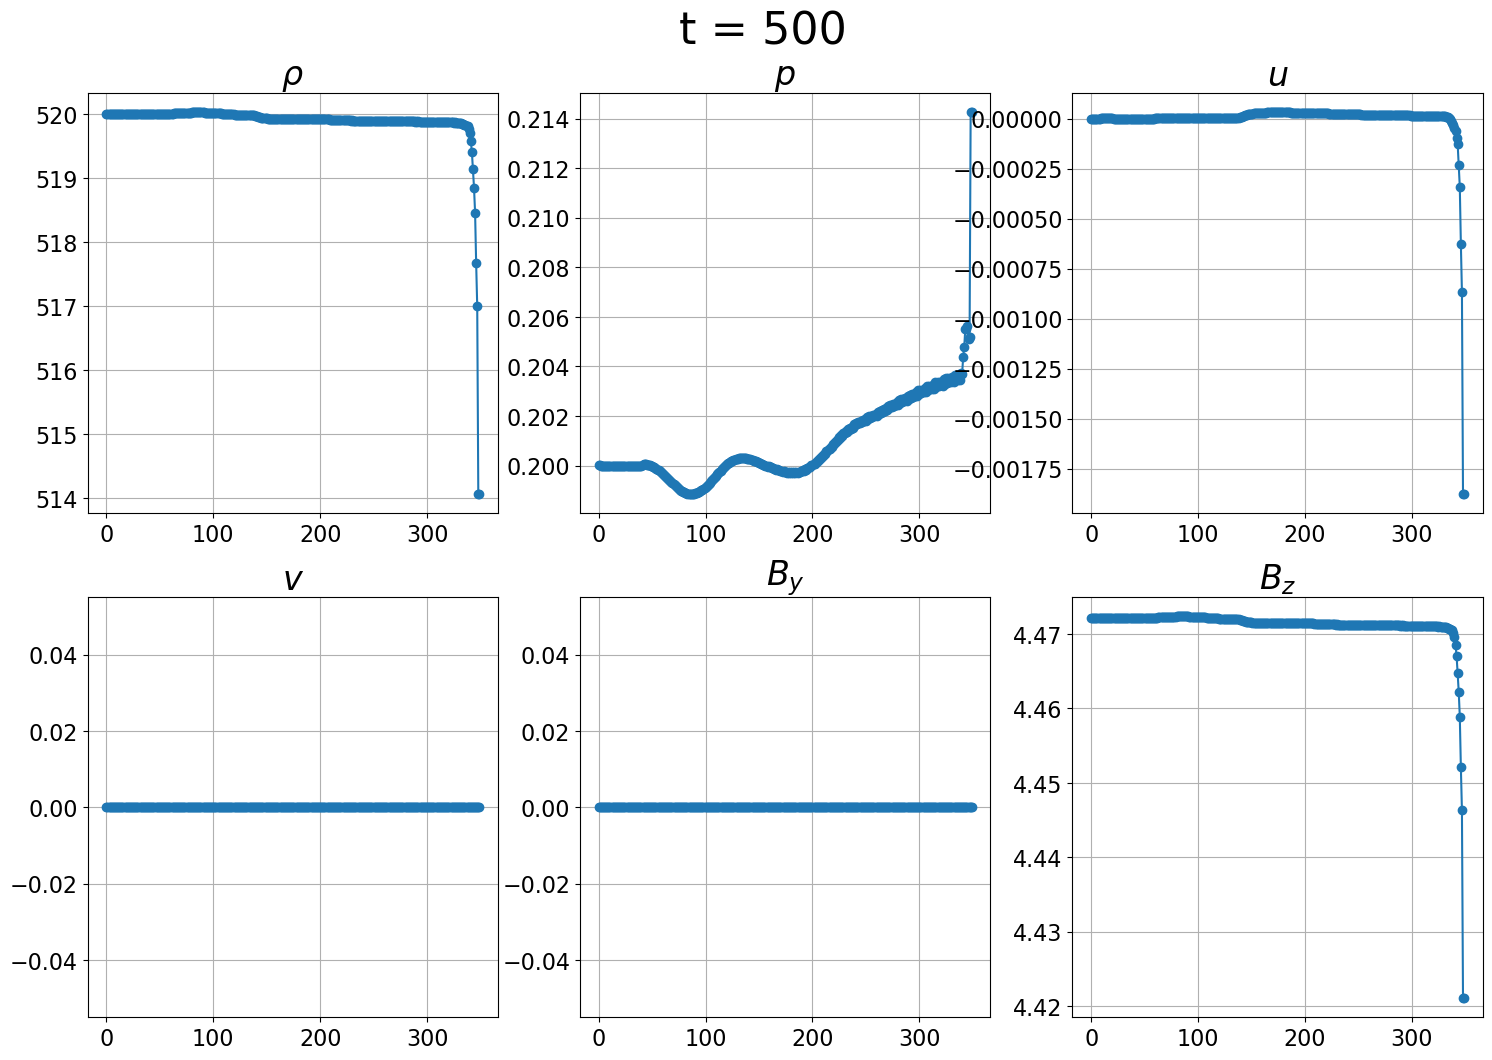

In [12]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

rho = U[0, :]
u = U[1, :] / rho 
v = U[2, :] / rho 
w = U[3, :] / rho 
Bx = U[4, :]
By = U[5, :]
Bz = U[6, :]
e = U[7, :]
p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

ax1.plot(x_coordinate_mhd, rho, marker='o')
ax2.plot(x_coordinate_mhd, p, marker='o')
ax3.plot(x_coordinate_mhd, u, marker='o')
ax4.plot(x_coordinate_mhd, v, marker='o')
ax5.plot(x_coordinate_mhd, By, marker='o')
ax6.plot(x_coordinate_mhd, Bz, marker='o')

ax1.set_title(r"$\rho$", fontsize=24)
ax2.set_title(r"$p$", fontsize=24)
ax3.set_title(r"$u$", fontsize=24)
ax4.set_title(r"$v$", fontsize=24)
ax5.set_title(r"$B_y$", fontsize=24)
ax6.set_title(r"$B_z$", fontsize=24)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)
ax6.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()

plt.suptitle(f"t = {k}", y=0.95, fontsize=32)

plt.show()

動画作成

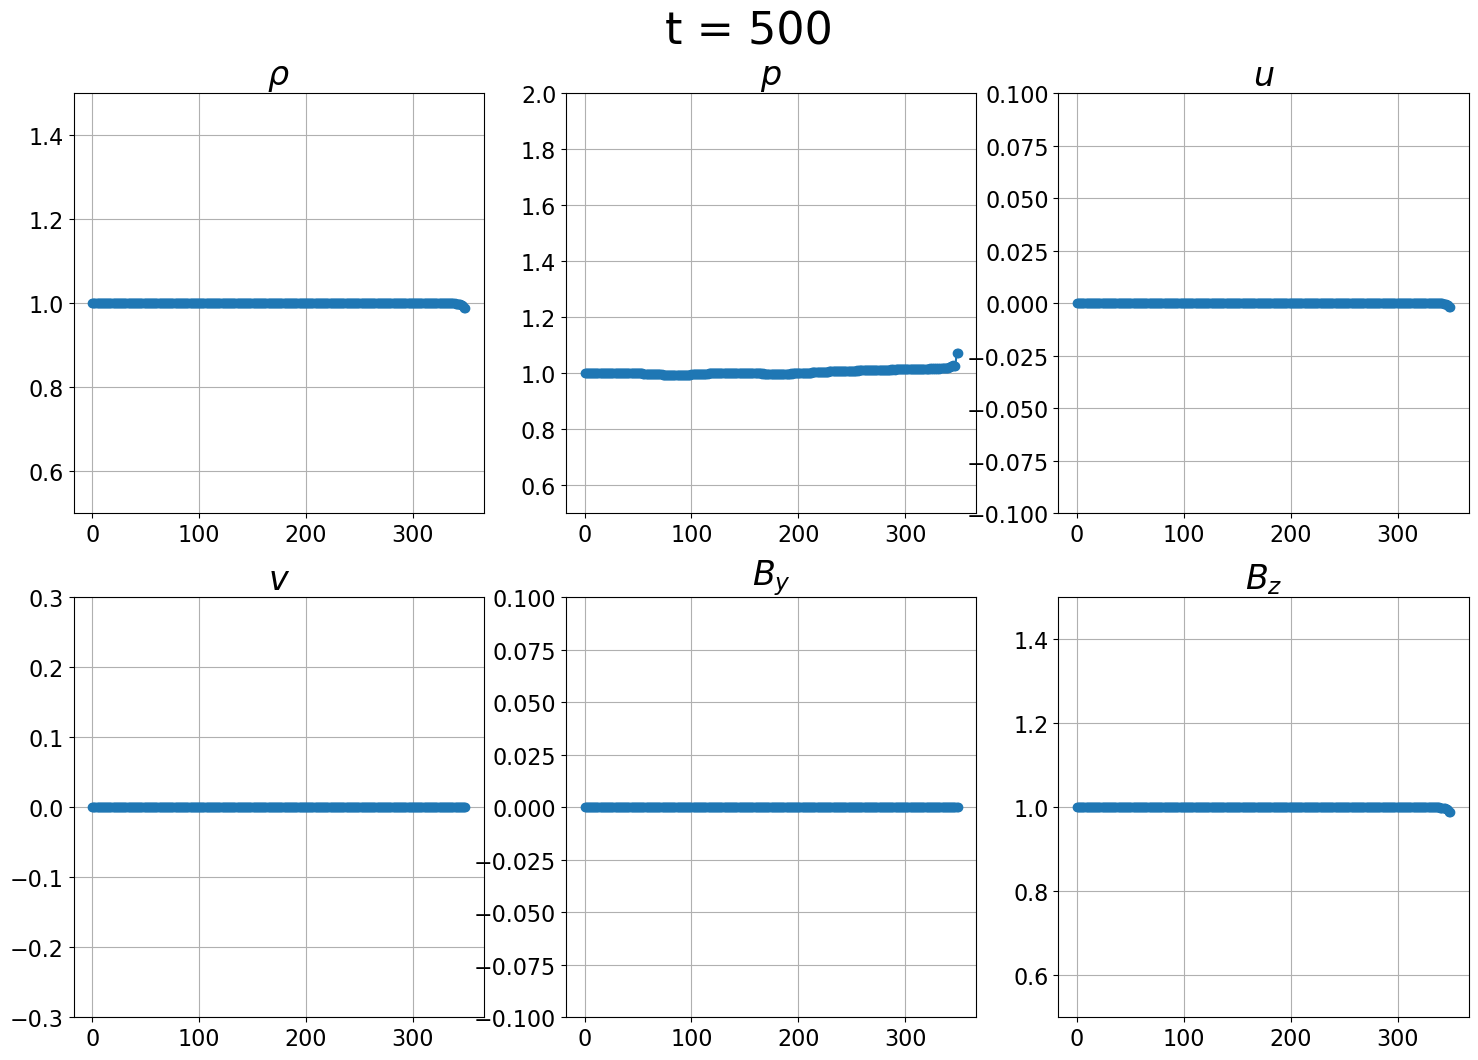

In [13]:
fig = plt.figure(figsize=(18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

filename = "Alfven_MHD.mp4"

interval = 10
for i in range(0, steps+1, interval):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax5.clear()
    ax6.clear()

    U = np.load(f"results_MHD_alfven/U1_{i}.npy")
    rho = U[0, :]
    u = U[1, :] / rho 
    v = U[2, :] / rho 
    w = U[3, :] / rho 
    Bx = U[4, :]
    By = U[5, :]
    Bz = U[6, :]
    e = U[7, :]
    p = (gamma_mhd-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    ax1.plot(x_coordinate_mhd, rho / rho0_mhd, marker='o')
    ax2.plot(x_coordinate_mhd, p / p0_mhd, marker='o')
    ax3.plot(x_coordinate_mhd, u, marker='o')
    ax4.plot(x_coordinate_mhd, v, marker='o')
    ax5.plot(x_coordinate_mhd, By / B0_mhd, marker='o')
    ax6.plot(x_coordinate_mhd, Bz / B0_mhd, marker='o')

    ax1.set_ylim(0.5, 1.5)
    ax2.set_ylim(0.5, 2.0)
    ax3.set_ylim(-0.1, 0.1)
    ax4.set_ylim(-0.3, 0.3)
    ax5.set_ylim(-0.1, 0.1)
    ax6.set_ylim(0.5, 1.5)

    ax1.set_title(r"$\rho$", fontsize=24)
    ax2.set_title(r"$p$", fontsize=24)
    ax3.set_title(r"$u$", fontsize=24)
    ax4.set_title(r"$v$", fontsize=24)
    ax5.set_title(r"$B_y$", fontsize=24)
    ax6.set_title(r"$B_z$", fontsize=24)
    ax1.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax3.tick_params(labelsize=16)
    ax4.tick_params(labelsize=16)
    ax5.tick_params(labelsize=16)
    ax6.tick_params(labelsize=16)
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax5.grid()
    ax6.grid()

    plt.suptitle(f"t = {i}", y=0.95, fontsize=32)

    fig.savefig(f'./pictures/{i}.png', dpi=200)


img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for i in range(0, steps, interval):
    img = cv2.imread(f'./pictures/{i}.png')
    video.write(img)
video.release()